In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from utils import *

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = [0], it's a 'non-cat' picture.


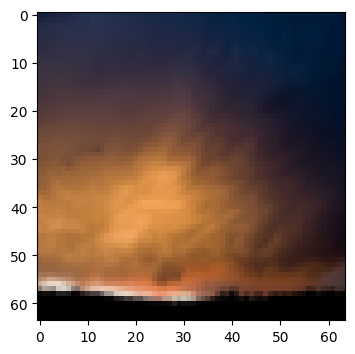

In [5]:
plt.imshow(train_x_orig[0])
print ("y = " + str(train_y[:,0]) + ", it's a '" + classes[np.squeeze(train_y[:,0])].decode("utf-8") +  "' picture.")

In [6]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Height/Width of each image: " + str(num_px) + "x" + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))

Number of training examples: 209
Number of testing examples: 50
Height/Width of each image: 64x64
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)


In [7]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.0
test_x = test_x_flatten/255.0

print ("train_x shape: " + str(train_x.shape))
print ("test_x shape: " + str(test_x.shape))

train_x shape: (12288, 209)
test_x shape: (12288, 50)


In [8]:
layers_dims = [train_x.shape[0], 20, 7, 5, 1] # 5-layer model

In [9]:
def nn_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                         # keep track of cost

    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        # Compute cost.
        cost = compute_cost(AL, Y)

        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters, costs

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


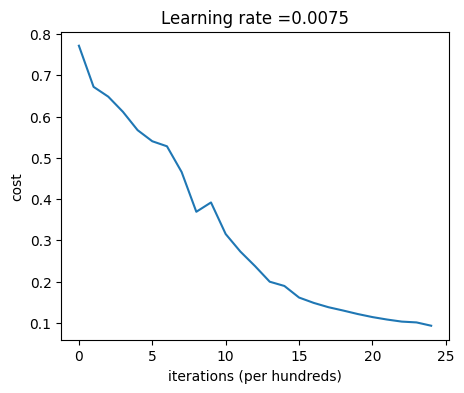

In [10]:
parameters = nn_model(train_x, train_y, layers_dims, learning_rate=0.0075, num_iterations = 2500, print_cost = True)

In [11]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

TypeError: tuple indices must be integers or slices, not str